<a href="https://colab.research.google.com/github/Shrey-Viradiya/HandsOnMachineLearning/blob/master/Processing%20Sequences%20Using%20RNNs%20and%20CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 22 15:20:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Processing Sequences Using RNNs and CNNs

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib as mpl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step. This is called a time series. In the first two examples there is a single value per time step, so these are univariate time series, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a multivariate time series. A typical task is to predict future values, which is called forecasting. Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called imputation.

## Generating Data

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)
#     return series

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


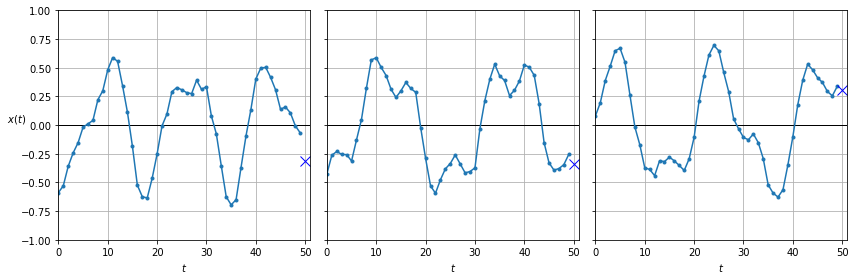

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.tight_layout()
plt.show()

## Computing Some Baselines

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series. This is called naive forecasting, and it is sometimes surprisingly difficult to outperform.


Naive predictions (just predict the last observed value):

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02082196

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50,1]),
    keras.layers.Dense(1)
])

In [9]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0543 - val_loss: 0.0269
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0131
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0048

In [10]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0040


0.004005116876214743

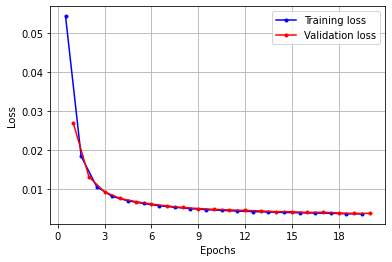

In [11]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Implementing a Simple RNN

In [12]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0895 - val_loss: 0.0746
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0653 - val_loss: 0.0541
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0465 - val_loss: 0.0375
Epoch 4/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0317 - val_loss: 0.0252
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0215 - val_loss: 0.0176
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0119 - val_lo

In [13]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.0111


0.011090396903455257

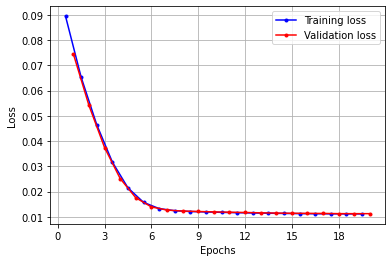

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [15]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [16]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 21s 96ms/step - loss: 0.0147 - val_loss: 0.0045
Epoch 2/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 3/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 21s 94ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 21s 94ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 9/20
219/219 [==============================] - 21s 94ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 20s 93ms/step - loss: 0.002

In [17]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 11ms/step - loss: 0.0030


0.0029847663827240467

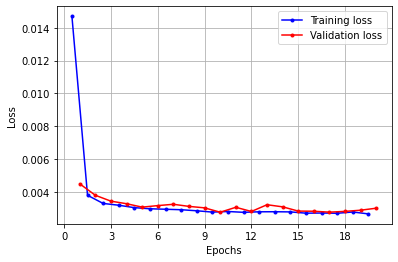

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [19]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [20]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0753 - val_loss: 0.0083
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 3/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/20
219/219 [==============================] - 15s 67ms/step - loss: 0.003

In [21]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0032


0.00323499389924109

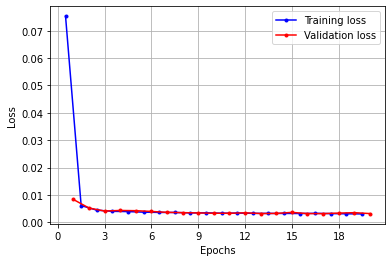

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Forecasting Several Steps Ahead

In [23]:
np.random.seed(42)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [24]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend()

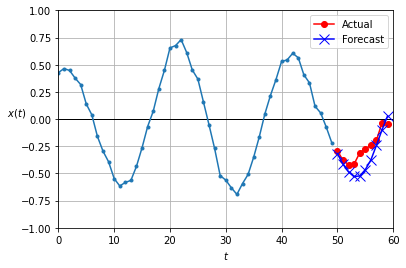

In [25]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [26]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [27]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [28]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0811 - val_loss: 0.0335
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0292 - val_loss: 0.0242
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0217 - val_loss: 0.0197
Epoch 4/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0181 - val_loss: 0.0165
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0148 - val_loss: 0.0129
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0134 - val_loss: 0.0123
Epoch 7/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0121 - val_loss: 0.0128
Epoch 8/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0118 - val_loss: 0.0134
Epoch 9/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0114 - val_loss: 0.0127
Epoch 10/20
219/219 [==============================] - 14s 66ms/step - loss: 0.010

In [29]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0109


0.010924643836915493

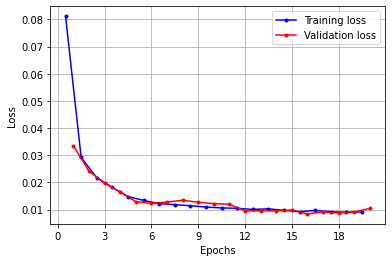

In [30]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [31]:
Y_pred = model.predict(X_new)

In [32]:
np.random.seed(42)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

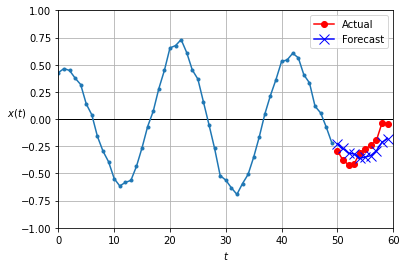

In [33]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [34]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead : step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test  = Y[9000:]

It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between X_train and Y_train). Isn’t that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a causal model.

To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step.

In [35]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [36]:
model.compile(loss = 'mse', optimizer = 'nadam', metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0664 - last_time_step_mse: 0.0612 - val_loss: 0.0083 - val_last_time_step_mse: 0.0201
Epoch 2/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0086 - last_time_step_mse: 0.0251 - val_loss: 0.0100 - val_last_time_step_mse: 0.0121
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0057 - last_time_step_mse: 0.0181 - val_loss: 0.0044 - val_last_time_step_mse: 0.0065
Epoch 4/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0045 - last_time_step_mse: 0.0147 - val_loss: 0.0031 - val_last_time_step_mse: 0.0154
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0040 - last_time_step_mse: 0.0133 - val_loss: 0.0086 - val_last_time_step_mse: 0.0409
Epoch 6/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0033 - last_time_step_mse: 0.0110 - val_loss: 0.0039 - val_last_time_step_mse: 0.0046
Epoch 7/20
219/2

In [37]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0010 - last_time_step_mse: 0.0019


[0.0010001405607908964, 0.001947689917869866]

In [38]:
np.random.seed(42)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

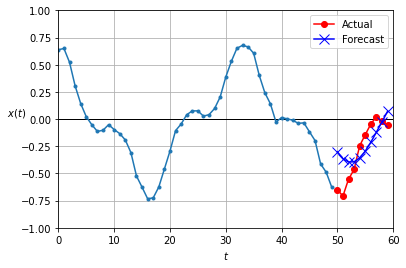

In [39]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Deep RNN with Batch Norm

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None,1]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 15s 68ms/step - loss: 0.2735 - last_time_step_mse: 0.1799 - val_loss: 0.1834 - val_last_time_step_mse: 0.0913
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.1110 - last_time_step_mse: 0.0814 - val_loss: 0.0393 - val_last_time_step_mse: 0.0640
Epoch 3/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0186 - last_time_step_mse: 0.0291 - val_loss: 0.0142 - val_last_time_step_mse: 0.0226
Epoch 4/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0115 - last_time_step_mse: 0.0222 - val_loss: 0.0094 - val_last_time_step_mse: 0.0204
Epoch 5/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0086 - last_time_step_mse: 0.0192 - val_loss: 0.0077 - val_last_time_step_mse: 0.0185
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0069 - last_time_step_mse: 0.0170 - val_loss: 0.0058 - val_last_time_step_mse: 0.0169
Epoch 7/20
219/2

## Deep RNNs with Layer Norm

In [45]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 34s 155ms/step - loss: 0.2118 - last_time_step_mse: 0.1201 - val_loss: 0.0218 - val_last_time_step_mse: 0.0253
Epoch 2/20
219/219 [==============================] - 33s 151ms/step - loss: 0.0116 - last_time_step_mse: 0.0223 - val_loss: 0.0084 - val_last_time_step_mse: 0.0193
Epoch 3/20
219/219 [==============================] - 33s 151ms/step - loss: 0.0073 - last_time_step_mse: 0.0209 - val_loss: 0.0066 - val_last_time_step_mse: 0.0204
Epoch 4/20
219/219 [==============================] - 33s 152ms/step - loss: 0.0062 - last_time_step_mse: 0.0213 - val_loss: 0.0059 - val_last_time_step_mse: 0.0212
Epoch 5/20
219/219 [==============================] - 33s 151ms/step - loss: 0.0057 - last_time_step_mse: 0.0215 - val_loss: 0.0056 - val_last_time_step_mse: 0.0210
Epoch 6/20
219/219 [==============================] - 33s 150ms/step - loss: 0.0054 - last_time_step_mse: 0.0216 - val_loss: 0.0053 - val_last_time_step_mse: 0.0213
Epoch 7/20

## LSTMs

In [53]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape = [None,1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train , epochs = 20, validation_data= (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0765 - last_time_step_mse: 0.0436 - val_loss: 0.0050 - val_last_time_step_mse: 0.0108
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0027 - last_time_step_mse: 0.0052 - val_loss: 0.0017 - val_last_time_step_mse: 0.0026
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - last_time_step_mse: 0.0019 - val_loss: 0.0012 - val_last_time_step_mse: 0.0013
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - last_time_step_mse: 0.0010 - val_loss: 9.5624e-04 - val_last_time_step_mse: 8.2140e-04
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 8.9983e-04 - last_time_step_mse: 7.6032e-04 - val_loss: 8.5463e-04 - val_last_time_step_mse: 7.0982e-04
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 8.2681e-04 - last_time_step_mse: 6.7407e-04 - val_loss: 8.0151e-04 - val_last_time_step_mse

In [54]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 5.9914e-04 - last_time_step_mse: 4.1295e-04


[0.0005991358193568885, 0.0004129481967538595]

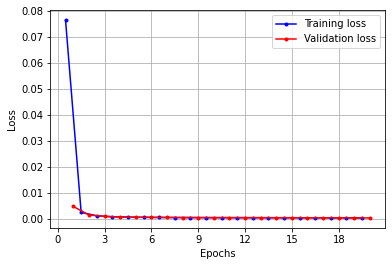

In [55]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

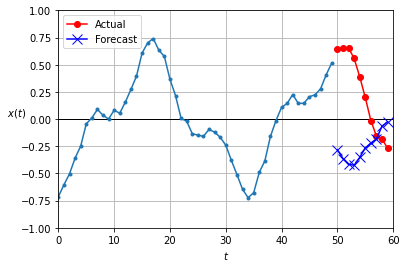

In [56]:
np.random.seed(42)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [57]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train , epochs = 20, validation_data= (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 32s 146ms/step - loss: 0.0735 - last_time_step_mse: 0.0416 - val_loss: 0.0056 - val_last_time_step_mse: 0.0106
Epoch 2/20
219/219 [==============================] - 32s 145ms/step - loss: 0.0030 - last_time_step_mse: 0.0067 - val_loss: 0.0019 - val_last_time_step_mse: 0.0049
Epoch 3/20
219/219 [==============================] - 32s 146ms/step - loss: 0.0016 - last_time_step_mse: 0.0037 - val_loss: 0.0013 - val_last_time_step_mse: 0.0024
Epoch 4/20
219/219 [==============================] - 32s 145ms/step - loss: 0.0012 - last_time_step_mse: 0.0018 - val_loss: 0.0010 - val_last_time_step_mse: 0.0012
Epoch 5/20
219/219 [==============================] - 31s 144ms/step - loss: 9.7595e-04 - last_time_step_mse: 0.0010 - val_loss: 9.1909e-04 - val_last_time_step_mse: 9.5346e-04
Epoch 6/20
219/219 [==============================] - 32s 145ms/step - loss: 8.7992e-04 - last_time_step_mse: 7.7266e-04 - val_loss: 8.4555e-04 - val_last_time_ste